# **Tesla Stock Price Prediction**

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

## **Load Data**

1. **Open:** The opening price of the stock on a particular trading day. This is the price at which the first trade is executed when the market opens.
2.  **High:** The highest price at which the stock traded during the trading day. It indicates the maximum value that traders were willing to pay for the stock on that day.
3. **Low:** The lowest price at which the stock traded during the trading day. This represents the minimum value for the stock within the trading day.
4. **Close:** The closing price of the stock for the day. It is the last price at which the stock was traded before the market closed. This is one of the most commonly reported and used prices because it reflects the final consensus value of the stock for the day.
5. **Volume:** The total number of shares or contracts traded for the stock during the trading day. It reflects the level of activity or liquidity for the stock. Higher volume indicates more trading activity and, typically, higher investor interest.
6. **Adj Close (Adjusted Close):** This is the closing price adjusted for corporate actions like `stock splits`, `dividends`, and `new stock offerings`. Adjusted close provides a more accurate reflection of a stock’s value and price movements over time because it accounts for events that could affect the stock price directly.

In [3]:
data = pd.read_csv("Tesla.csv - Tesla.csv.csv")

In [4]:
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [5]:
data.shape

(1692, 7)

`1692 records and 7 features`

In [6]:
# Info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1692 non-null   object 
 1   Open       1692 non-null   float64
 2   High       1692 non-null   float64
 3   Low        1692 non-null   float64
 4   Close      1692 non-null   float64
 5   Volume     1692 non-null   int64  
 6   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 92.7+ KB


In [7]:
## Missing data points
data.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0
Adj Close,0


**Plot of open price distribution**

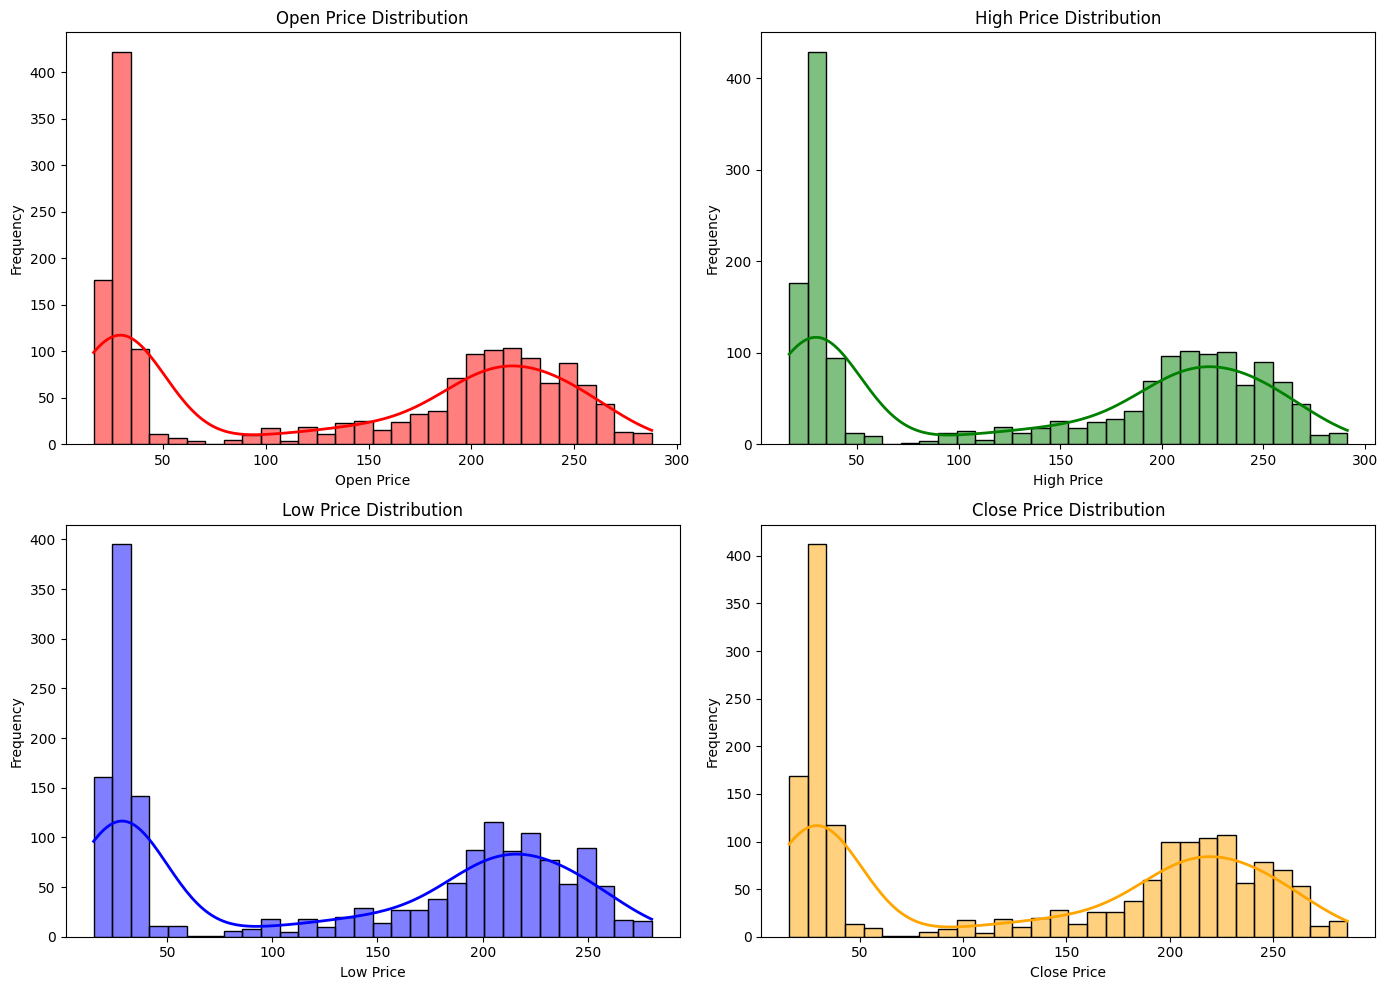

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

features = ['Open', 'High', 'Low', 'Close']
titles = ['Open Price Distribution', 'High Price Distribution', 'Low Price Distribution', 'Close Price Distribution']
bar_colors = ["red", "green", "blue", "orange"]
kde_colors = ["black", "magenta", "cyan", "purple"]

# Plotting loop
for ax, feature, title, bar_color, kde_color in zip(axes.flat, features, titles, bar_colors, kde_colors):
    sns.histplot(data[feature], bins=30, kde=True, ax=ax, color=bar_color, line_kws={'color': kde_color, 'linewidth': 2})
    ax.set_title(title)
    ax.set_xlabel(f'{feature} Price')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [9]:
data.describe()

,Open,High,Low,Close,Volume,Adj Close
count,1692.000000,1692.000000,1692.000000,1692.000000,1.692000e+03,1692.000000
mean,132.441572,134.769698,129.996223,132.428658,4.270741e+06,132.428658
std,94.309923,95.694914,92.855227,94.313187,4.295971e+06,94.313187
min,16.139999,16.629999,14.980000,15.800000,1.185000e+05,15.800000
25%,30.000000,30.650000,29.215000,29.884999,1.194350e+06,29.884999
50%,156.334999,162.370002,153.150002,158.160004,3.180700e+06,158.160004
75%,220.557495,224.099999,217.119999,220.022503,5.662100e+06,220.022503
max,287.670013,291.420013,280.399994,286.040009,3.716390e+07,286.040009


## **Data splitting : Train and Validation set**

In [10]:
length_data = len(data)
split_ratio = 0.70 # Training size 70% and Testing Size 30%
length_train = round(length_data*split_ratio)
length_validation = length_data - length_train

In [11]:
print("Data Length:", length_data)
print("Train data length:", length_train)
print("Validation data length:", length_validation)

Data Length: 1692
Train data length: 1184
Validation data length: 508


**Training Data**

In [12]:
# Train data (we are predicting opening price)
train_data = data[:length_train].iloc[:,:2]

In [13]:
train_data['Date'] = pd.to_datetime(train_data['Date']) #converting to date time format
train_data.head()

,Date,Open
0,2010-06-29,19.000000
1,2010-06-30,25.790001
2,2010-07-01,25.000000
3,2010-07-02,23.000000
4,2010-07-06,20.000000


**Validation Data**

In [14]:
validation_data = data[length_train:].iloc[:,:2]
validation_data['Date'] = pd.to_datetime(validation_data['Date'])
validation_data.head()

,Date,Open
1184,2015-03-13,188.949997
1185,2015-03-16,192.000000
1186,2015-03-17,195.429993
1187,2015-03-18,194.960007
1188,2015-03-19,202.000000


## **Converting training dataset to array**

- Most RNN layers (like LSTM or GRU) expect input data in a 3D shape: `(batch_size, timesteps, features)`.
- However, when preparing the data before creating sequences `(timesteps)`, libraries often expect each individual data point (e.g., the opening price at a specific time) to be represented as a 2D array of `(samples, features)`.
- In our case, we have one feature (the 'Open' price).
`np.reshape(dataset_train, (-1, 1))` transforms the 1D array (n,) into a 2D array (n, 1).
- The `-1` tells NumPy to automatically calculate the number of rows based on the array's size and the other dimension specified `(which is 1)`.
- The `1` indicates that there is one feature.

In [15]:
dataset_train = train_data.Open.values
dataset_train

array([ 19.      ,  25.790001,  25.      , ..., 188.460007, 191.149994,
       193.75    ])

In [16]:
dataset_train.shape

(1184,)

In [17]:
dataset_train.ndim

1

**Convert 1D array to 2D array**

In [18]:
dataset_train = np.reshape(dataset_train, (-1,1))

In [19]:
dataset_train[:100]

array([[19.      ],
       [25.790001],
       [25.      ],
       [23.      ],
       [20.      ],
       [16.4     ],
       [16.139999],
       [17.58    ],
       [17.950001],
       [17.389999],
       [17.940001],
       [19.940001],
       [20.700001],
       [21.370001],
       [21.85    ],
       [20.66    ],
       [20.5     ],
       [21.190001],
       [21.5     ],
       [20.91    ],
       [20.549999],
       [20.77    ],
       [20.200001],
       [20.5     ],
       [21.      ],
       [21.950001],
       [21.540001],
       [20.1     ],
       [19.9     ],
       [19.65    ],
       [18.690001],
       [17.799999],
       [18.18    ],
       [18.450001],
       [18.959999],
       [19.59    ],
       [18.540001],
       [18.65    ],
       [19.09    ],
       [19.25    ],
       [19.16    ],
       [19.889999],
       [19.75    ],
       [19.700001],
       [19.66    ],
       [19.620001],
       [20.370001],
       [20.870001],
       [20.610001],
       [20.66    ],


## **Normalization/Feature Scaling**

In [20]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
dataset_train_scaled = sc.fit_transform(dataset_train)

In [21]:
print(f"Before Normalization : min values is [{dataset_train.min()}], max value is [{dataset_train.max()}]")
print(f"After Normalization : min values is [{dataset_train_scaled.min()}], max value is [{dataset_train_scaled.max()}]")

Before Normalization : min values is [16.139999], max value is [287.670013]
After Normalization : min values is [0.0], max value is [1.0]


**Let us visualize the line chart for Tesla Stock Open price**

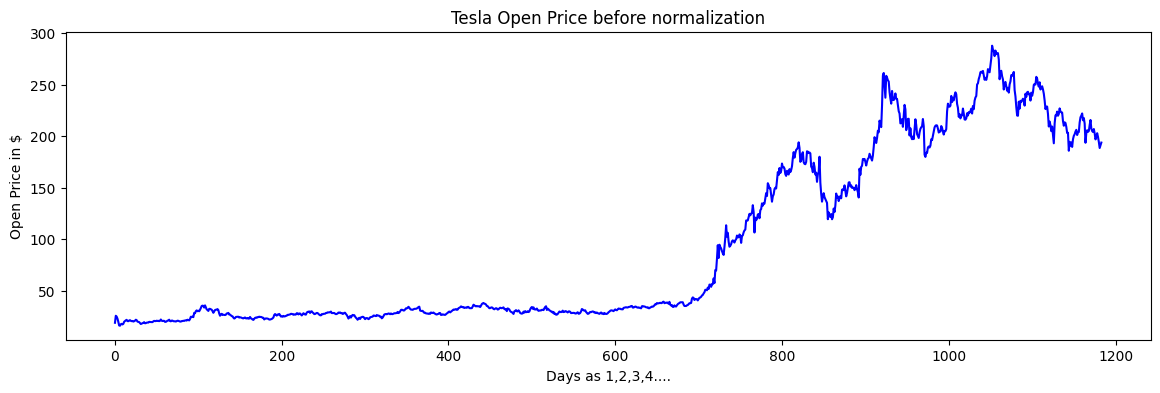

In [22]:
# Before normalisation
plt.subplots(figsize = (14,4))
plt.plot(dataset_train, color='blue', label='Tesla Stock Open Price')
plt.title("Tesla Open Price before normalization")
plt.xlabel('Days as 1,2,3,4....')
plt.ylabel('Open Price in $')
plt.show()

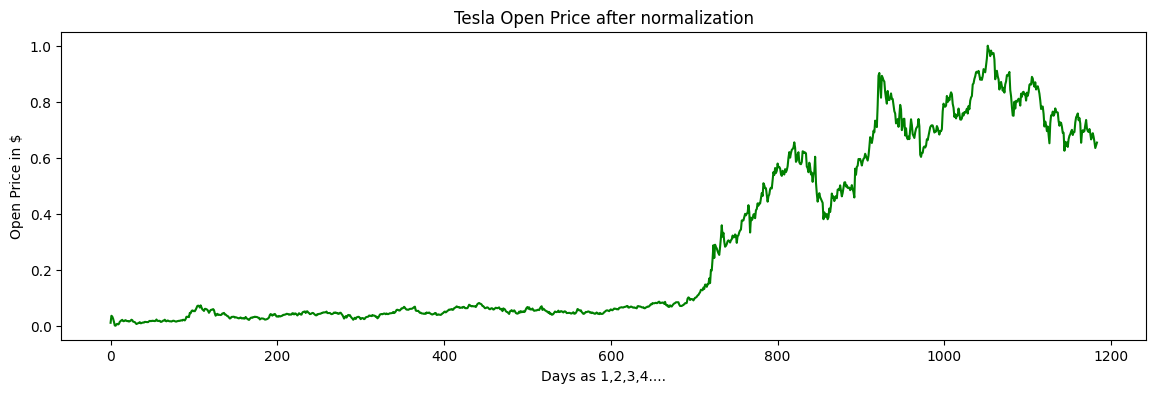

In [23]:
# After Normalisation
plt.subplots(figsize = (14,4))
plt.plot(dataset_train_scaled, color='g', label='Tesla Stock Open Price')
plt.title("Tesla Open Price after normalization")
plt.xlabel('Days as 1,2,3,4....')
plt.ylabel('Open Price in $')
plt.show()

**Independent and Dependent Features**

In [24]:
# Independent Feature
X_train = []
# Dependent Feature
y_train = []

time_step = 50 # time_step defines the length of each input sequence, it is like a window that we passes over dataset to get a set of values

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])

# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)

In [25]:
print("Shape of X_train before reshape:", X_train.shape)
print("Shape of y_train before reshape:", y_train.shape)

Shape of X_train before reshape: (1134, 50)
Shape of y_train before reshape: (1134,)


`(batch_size/samples, timesteps, features)`

- `batch_size/samples (i.e., X_train.shape[0])`: The number of individual sequences you are feeding into the network.
- `timesteps (i.e., X_train.shape[1])`: The length of each sequence (how many past data points the RNN looks at for each prediction).
- `features (i.e., 1)`: The number of variables you are considering at each time step.

In [26]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (1134, 50, 1)
Shape of y_train after reshape : (1134, 1)


# **Creating RNN Model**

In [27]:
import tensorflow as tf
from keras.models import Sequential # we can use keras directly
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN

In [28]:
### Intialize the RNN object
regressor = Sequential()

### Adding the first RNN layer and drop regularization
regressor.add(SimpleRNN(units = 50, activation='tanh', return_sequences= True, input_shape =(X_train.shape[1],1)))

# Adding second RNN layer and dropout regulatization
regressor.add( SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
regressor.add(Dropout(0.2))

# Adding third RNN layer and dropout regulatization
regressor.add(SimpleRNN(units = 50,activation = "tanh",return_sequences = True))
regressor.add(Dropout(0.2))

# Adding fourth RNN layer and dropout regulatization
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))

### Adding the output layer
regressor.add(Dense(units=1)) # a fully connected layer with onen neuron is added as the output layer

### Compiling RNN
regressor.compile(optimizer='adam', loss="mean_squared_error", metrics=['r2_score'])

#### Training the RNN
history = regressor.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 0.4840 - r2_score: -3.9465
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1848 - r2_score: -0.8862
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1273 - r2_score: -0.2996
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0817 - r2_score: 0.1571
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0515 - r2_score: 0.4805
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0363 - r2_score: 0.6293
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0315 - r2_score: 0.6927
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0269 - r2_score: 0.7205
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0233 - r2_score: 0.7603
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0144 - r2_score: 0.8558
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0146 - r2_score: 0.8501
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss:

**Evaluating the model on Training Data**

In [29]:
y_pred_train = regressor.predict(X_train) #predictions
y_pred_train = sc.inverse_transform(y_pred_train) # scaling back from 0-1 to original

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


In [30]:
y_train_reverse_scaled = sc.inverse_transform(y_train) # scaling back from 0-1 to original
y_train_reverse_scaled.shape

(1134, 1)

In [31]:
from sklearn.metrics import r2_score
r2 = r2_score(y_train_reverse_scaled, y_pred_train)

print(f"\nCalculated R-squared (R2) score for Training Dataset : {r2}")


Calculated R-squared (R2) score for Training Dataset : 0.9946221971336522


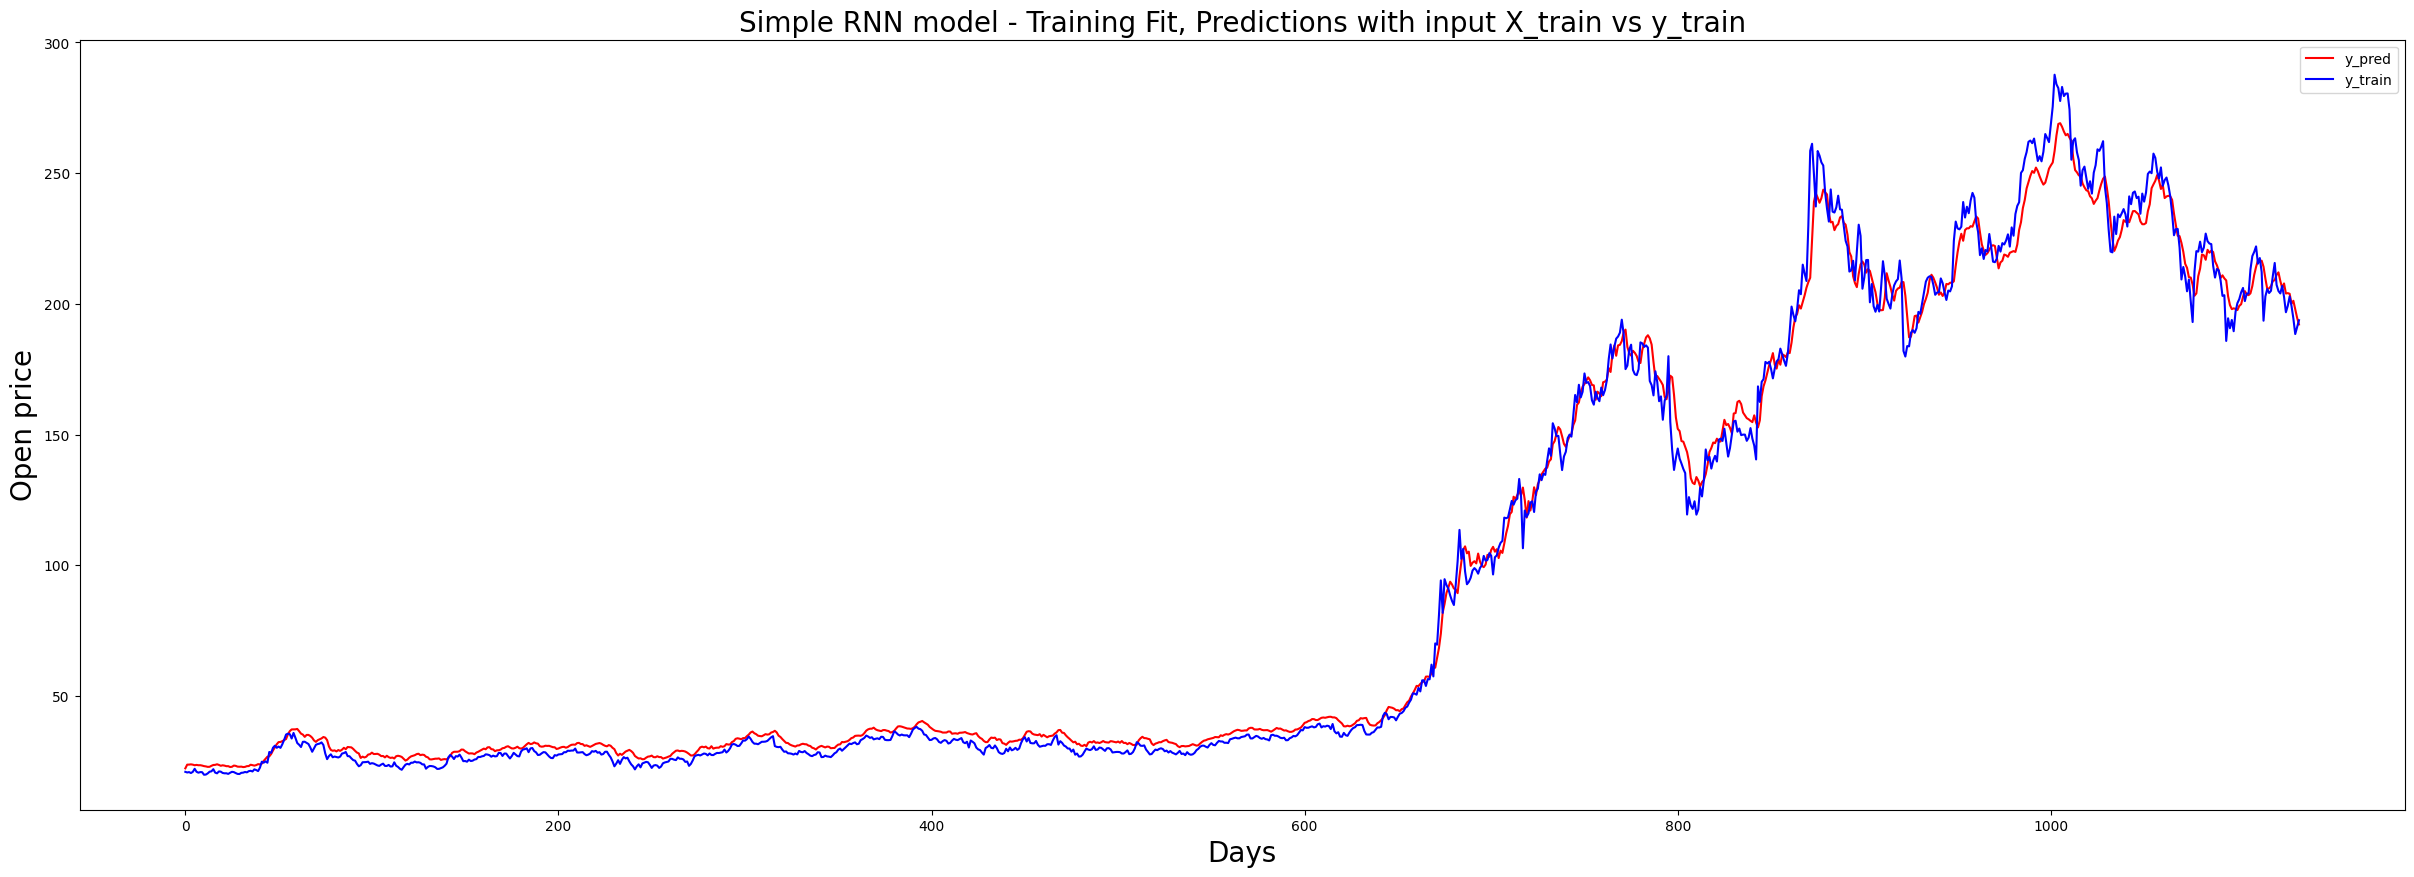

In [32]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_train, color = "r", label = "y_pred" )
plt.plot(y_train_reverse_scaled, color = "b", label = "y_train")
plt.xlabel("Days", fontsize = 20)
plt.ylabel("Open price", fontsize = 20)
plt.title("Simple RNN model - Training Fit, Predictions with input X_train vs y_train", fontsize = 20)
plt.legend()
plt.show()

**Evaluating the model on Validation Data**

In [33]:
# converting validation data to array
dataset_validation = validation_data.Open.values #getting open price for validation data and getting it into array
dataset_validation = np.reshape(dataset_validation, (-1,1)) # converting 1D array to 2D array
scaled_dataset_validation =  sc.transform(dataset_validation)  # scaling open values to between 0 and 1
print("Shape of scaled validation dataset :",scaled_dataset_validation.shape)

Shape of scaled validation dataset : (508, 1)


**Creating Test dataset from validation data**

In [34]:
# Creating X_test and y_test
X_test = []
y_test = []

for i in range(time_step, length_validation):
    X_test.append(scaled_dataset_validation[i-time_step:i,0])
    y_test.append(scaled_dataset_validation[i,0])

# Converting to array
X_test, y_test = np.array(X_test), np.array(y_test)

In [35]:
print("Shape of X_test before reshape :",X_test.shape)
print("Shape of y_test before reshape :",y_test.shape)

Shape of X_test before reshape : (458, 50)
Shape of y_test before reshape : (458,)


In [36]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # reshape to 3D array
y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array

**Evaluating the trained model with the Testing dataset**

In [37]:
y_pred_of_test = regressor.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [38]:
r2 = r2_score(y_test, y_pred_of_test)

print(f"\nCalculated R-squared (R2) score for Testing Dataset: {r2}")


Calculated R-squared (R2) score for Testing Dataset: 0.878237575267619


In [39]:
y_pred_of_test.min(), y_pred_of_test.max()

(np.float32(0.5291792), np.float32(0.91395444))

In [40]:
### Scaling back
y_pred_of_test = sc.inverse_transform(y_pred_of_test)

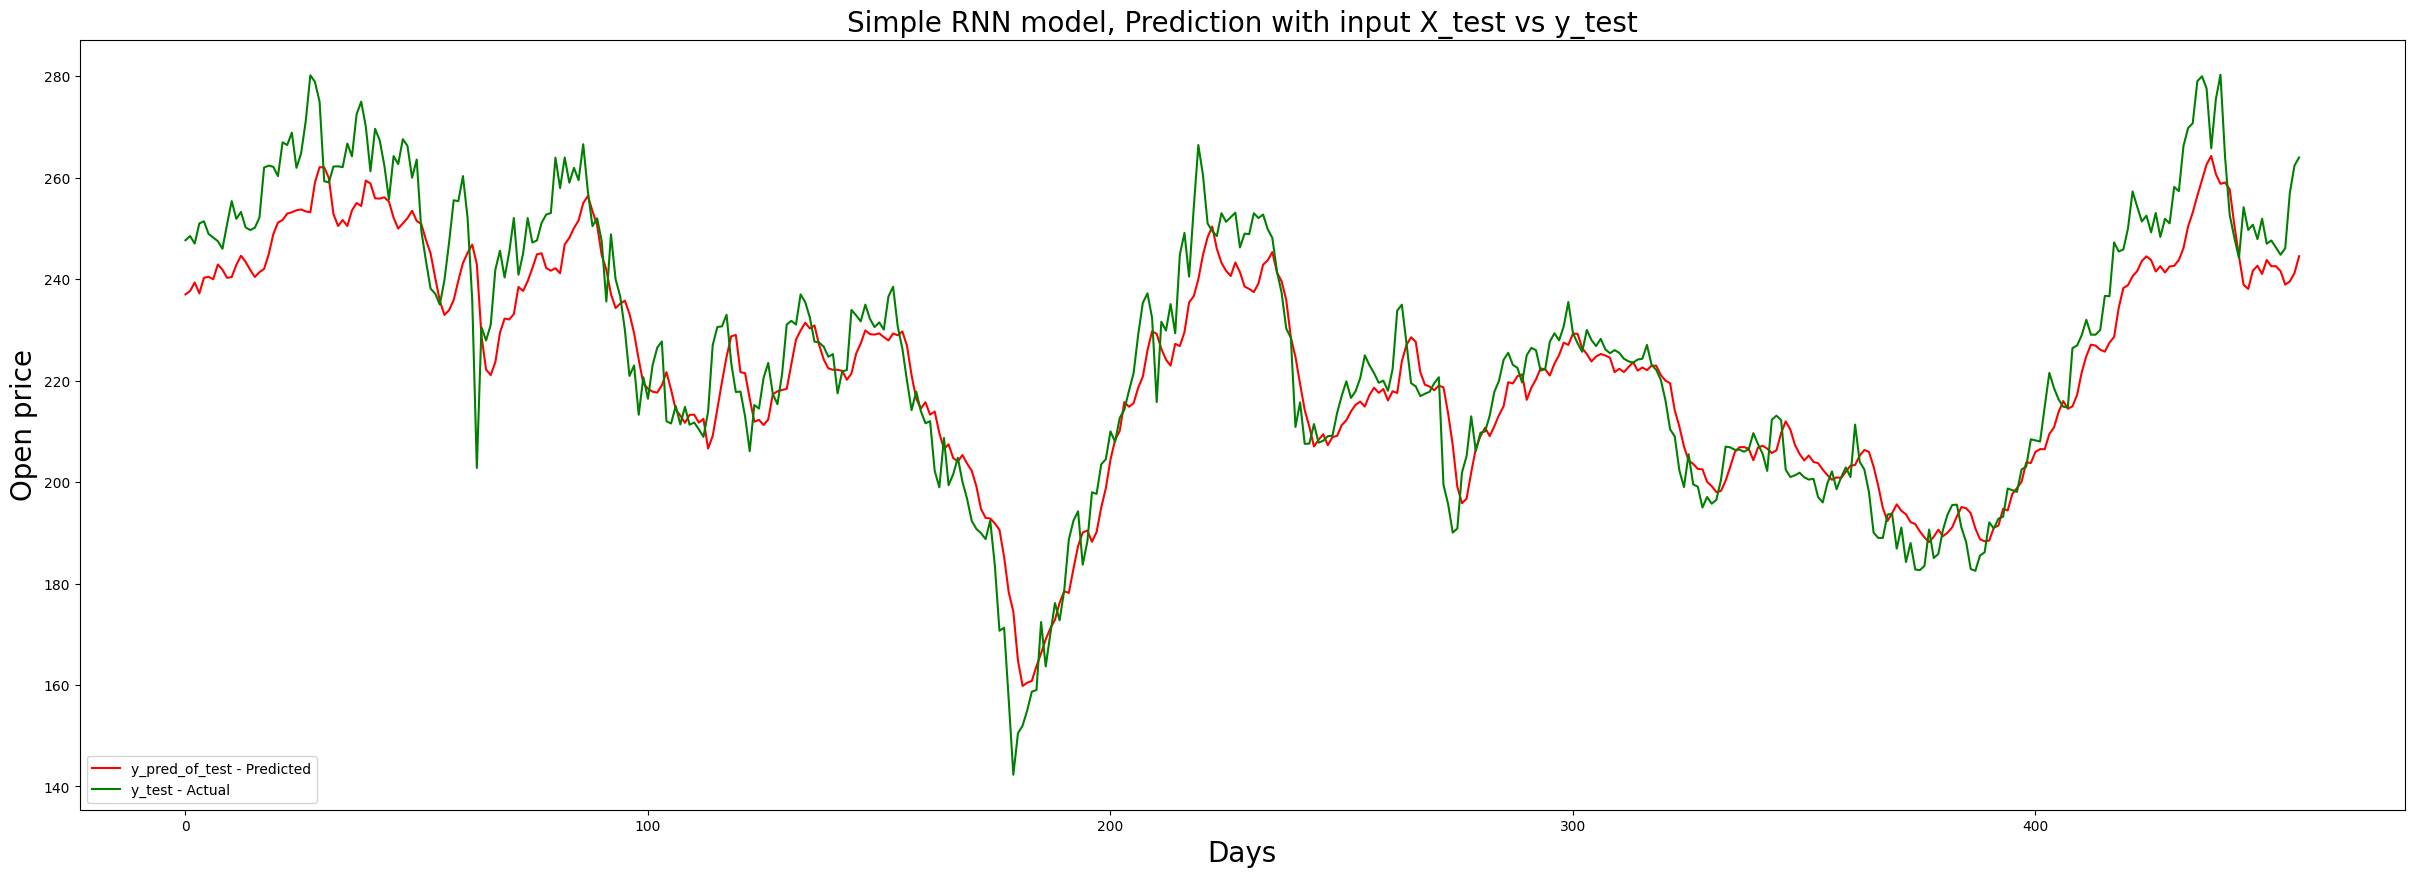

In [41]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test - Predicted", c = "red")
plt.plot(sc.inverse_transform(y_test), label = "y_test - Actual", c = "g")
plt.xlabel("Days", fontsize = 20)
plt.ylabel("Open price", fontsize = 20)
plt.title("Simple RNN model, Prediction with input X_test vs y_test", fontsize = 20)
plt.legend()
plt.show()

**SIMPLE RNN Model, Train-Validation-Prediction**

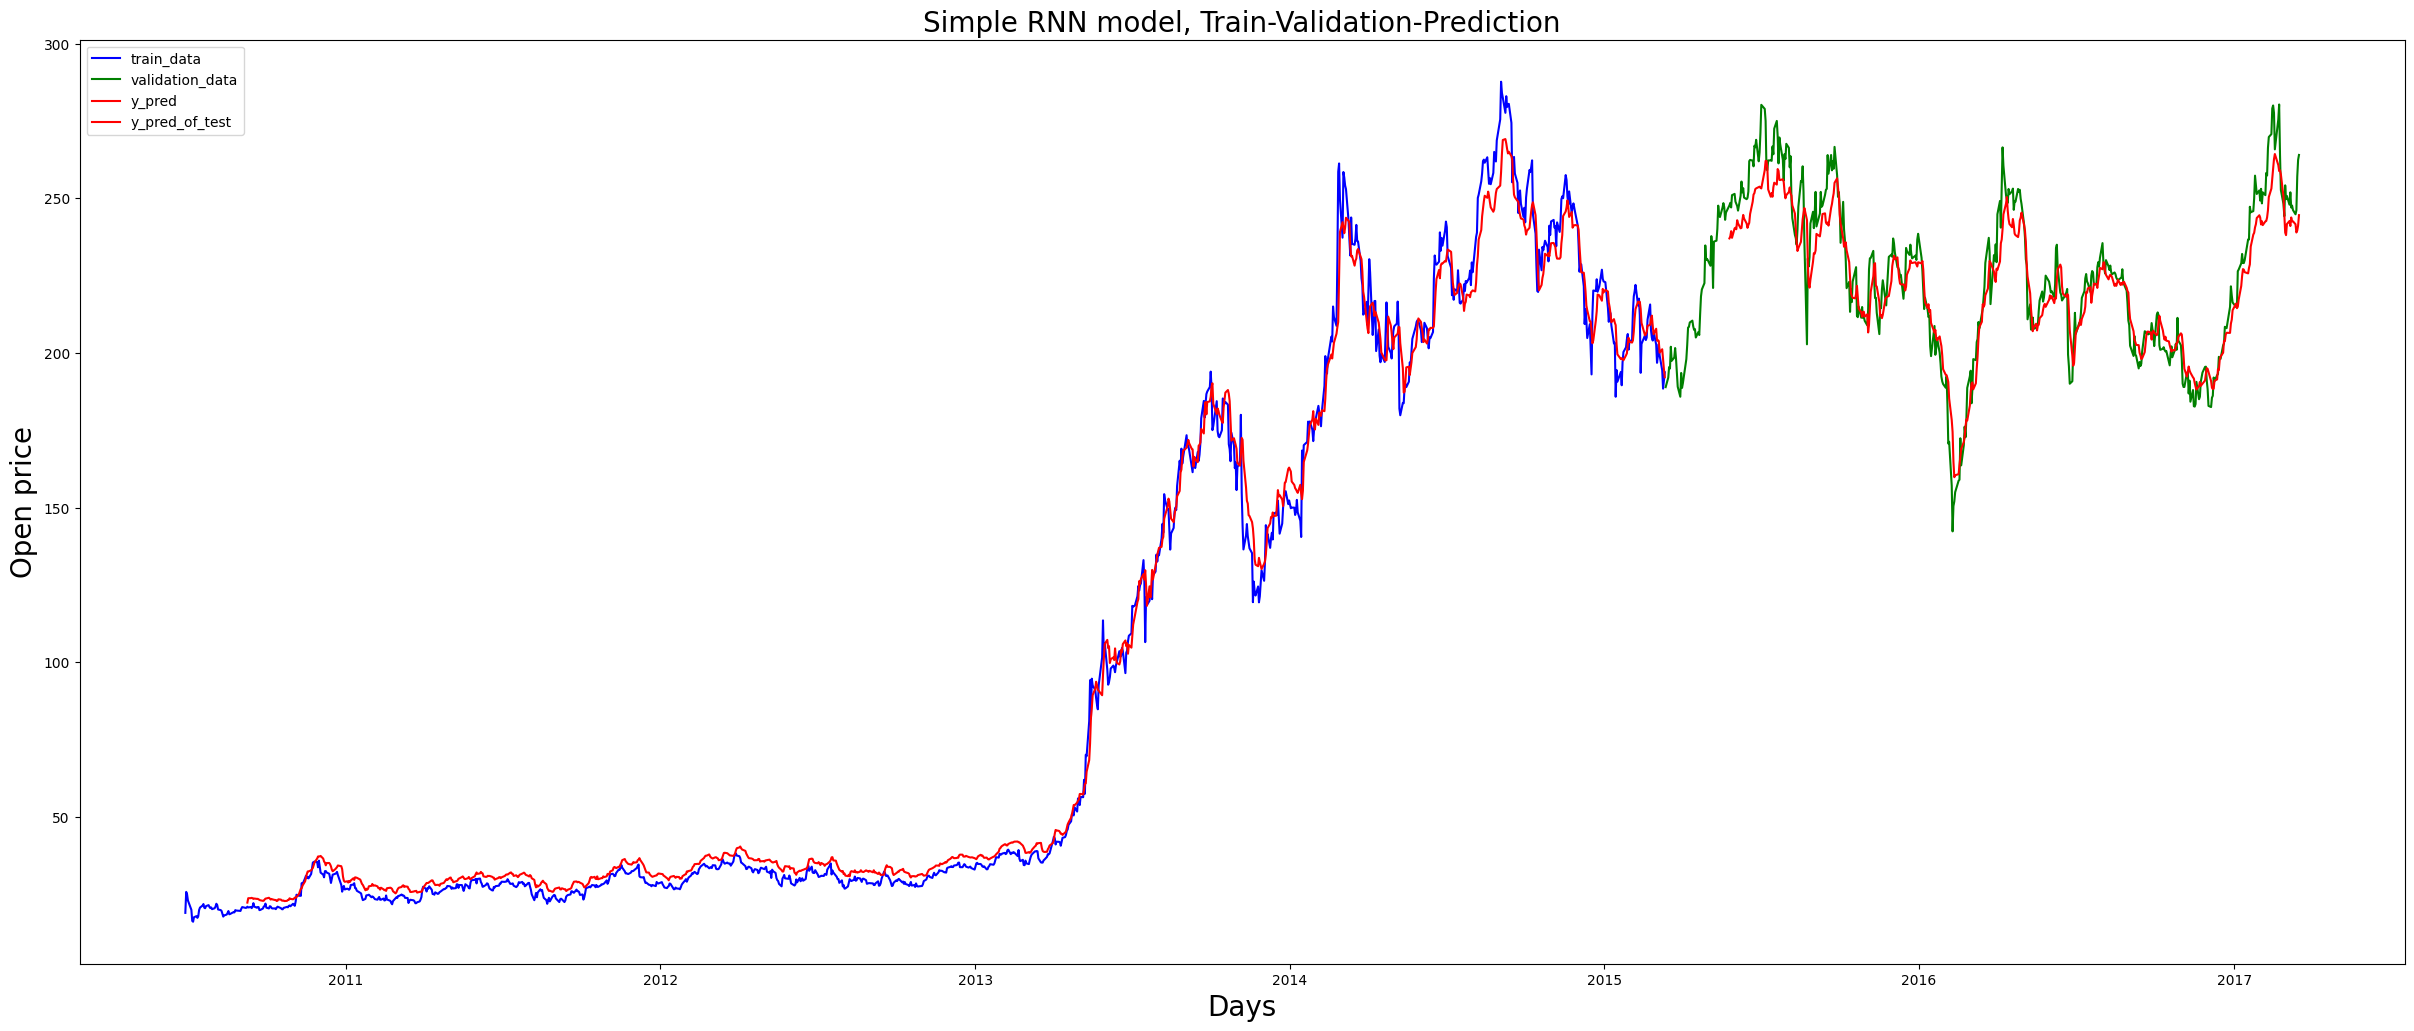

In [42]:
# Visualisation
plt.subplots(figsize =(30,12))
plt.plot(train_data.Date, train_data.Open, label = "train_data", color = "b")
plt.plot(validation_data.Date, validation_data.Open, label = "validation_data", color = "g")
plt.plot(train_data.Date.iloc[time_step:], y_pred_train, label = "y_pred", color = "r")
plt.plot(validation_data.Date.iloc[time_step:], y_pred_of_test, label = "y_pred_of_test", color = "r")
plt.xlabel("Days", fontsize = 20)
plt.ylabel("Open price", fontsize = 20)
plt.title("Simple RNN model, Train-Validation-Prediction", fontsize = 20)
plt.legend()
plt.show()

In [43]:
import plotly.graph_objects as go

fig = go.Figure()

# Train Data
fig.add_trace(go.Scatter(x=train_data.Date, y=train_data.Open,
                         mode='lines', name='train_data', line=dict(color='blue')))

# Validation Data
fig.add_trace(go.Scatter(x=validation_data.Date, y=validation_data.Open,
                         mode='lines', name='validation_data', line=dict(color='green')))

# Flatten the predictions to 1D
y_pred_train_flat = [x[0] for x in y_pred_train]
y_pred_of_test_flat = [x[0] for x in y_pred_of_test]


# Train Predictions
fig.add_trace(go.Scatter(x=train_data.Date.iloc[time_step:], y=y_pred_train_flat,
                         mode='lines', name='y_pred (train)',
                         line=dict(color='red')))

# Validation/Test Predictions
fig.add_trace(go.Scatter(x=validation_data.Date.iloc[time_step:], y=y_pred_of_test_flat,
                         mode='lines', name='y_pred_of_test',
                         line=dict(color='red')))


fig.update_layout(
    title='Simple RNN model, Train-Validation-Prediction',
    xaxis_title='Days',
    yaxis_title='Open price',
    width=1200,
    height=600,
    legend=dict(x=0, y=1.0),
    template='plotly_dark'
)

fig.show()


# **Creating LSTM Model**

In [44]:
y_train.min(), y_train.max()

(np.float64(0.013810627947745034), np.float64(1.0))

In [45]:
from keras.layers import LSTM

In [46]:
# LSTM model object
model_lstm = Sequential()

### First LSTM Layer
model_lstm.add(LSTM(64, return_sequences=True, input_shape = (X_train.shape[1],1))) #64 LSTM Units

### Second LSTM Layer
model_lstm.add(LSTM(64, return_sequences = False))

### Adding Dense Layers
model_lstm.add(Dense(64)) # A fully connected layer 32 neurons

### Output Layer with single neuron
model_lstm.add(Dense(1))

### Compiling the model
model_lstm.compile(loss="mean_squared_error", optimizer ="adam", metrics = ["r2_score"])

### Training the model
history2 = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0518 - r2_score: 0.4873
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0015 - r2_score: 0.9846
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0011 - r2_score: 0.9887
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0010 - r2_score: 0.9896
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0011 - r2_score: 0.9882
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0011 - r2_score: 0.9887
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 9.3532e-04 - r2_score: 0.9905
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0011 - r2_score: 0.9890
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 8.9186e-04 - r2_score: 0.9910
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 9.7772e-04 - r2_score: 0.9902
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 8.4216e-04 - r2_score: 0.9915
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/

**Evaluation**

In [47]:
y_pred_of_test = model_lstm.predict(X_test)
r2 = r2_score(y_test, y_pred_of_test)

print(f"\nCalculated R-squared (R2) score for Testing Dataset: {r2}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step

Calculated R-squared (R2) score for Testing Dataset: 0.923637988108966


In [48]:
y_pred_of_train = model_lstm.predict(X_train)
r2 = r2_score(y_train, y_pred_of_train)

print(f"\nCalculated R-squared (R2) score for Training Dataset: {r2}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Calculated R-squared (R2) score for Training Dataset: 0.9963969807840648


In [49]:
y_pred_of_test = sc.inverse_transform(y_pred_of_test)
y_pred_of_train = sc.inverse_transform(y_pred_of_train)
y_train = sc.inverse_transform(y_train)
y_test = sc.inverse_transform(y_test)

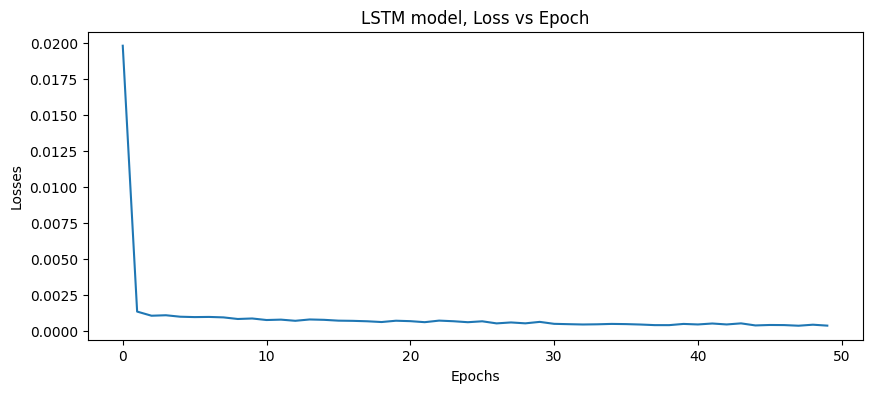

In [50]:
plt.figure(figsize=(10,4))
plt.plot(history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Loss vs Epoch")
plt.show()

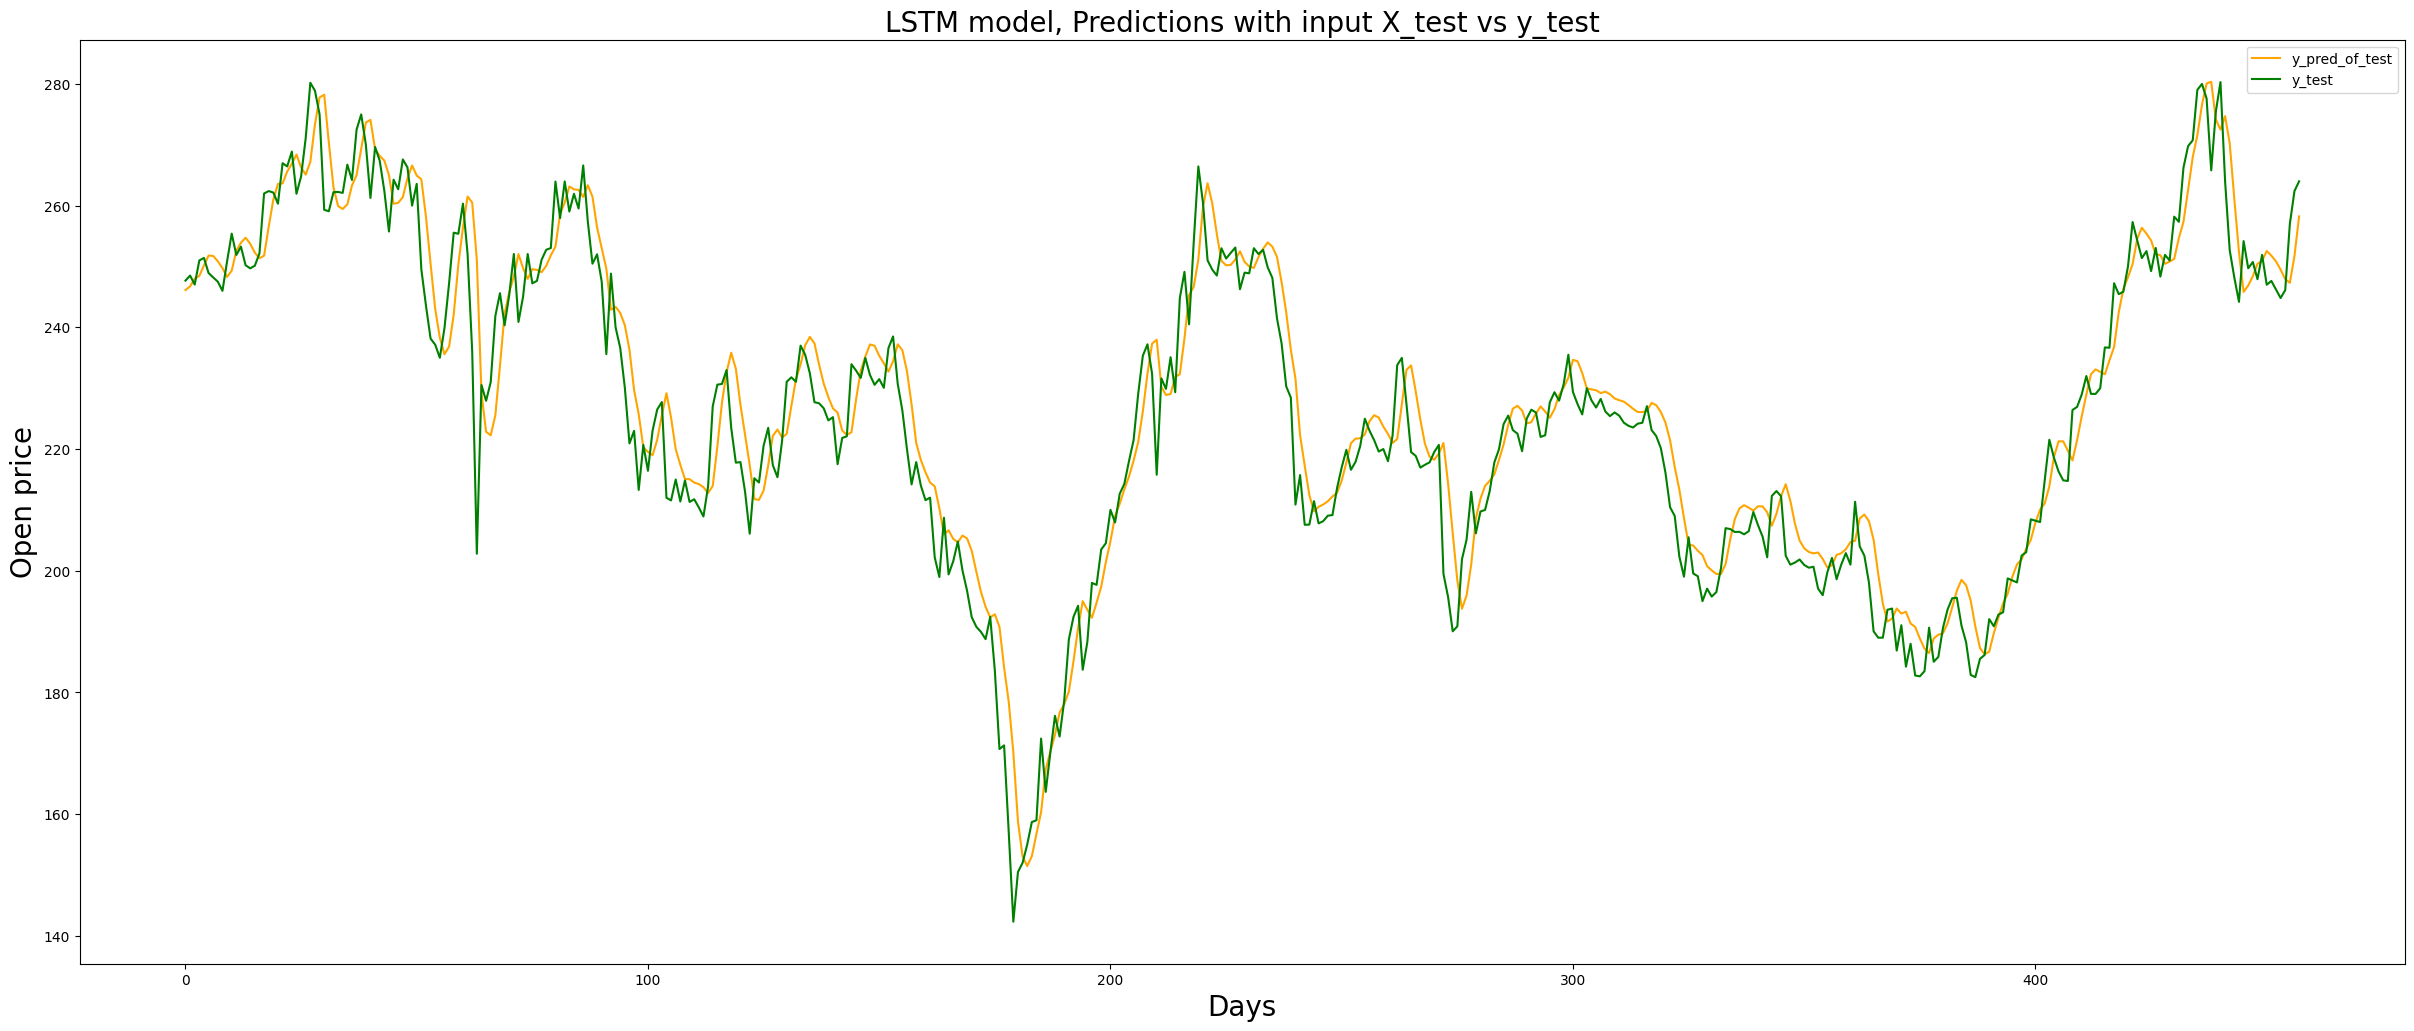

In [51]:
plt.subplots(figsize =(30,12))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange" )
plt.plot(y_test, label = "y_test", color = "g")
plt.xlabel("Days", fontsize = 20)
plt.ylabel("Open price", fontsize = 20)
plt.title("LSTM model, Predictions with input X_test vs y_test", fontsize = 20)
plt.legend()
plt.show()

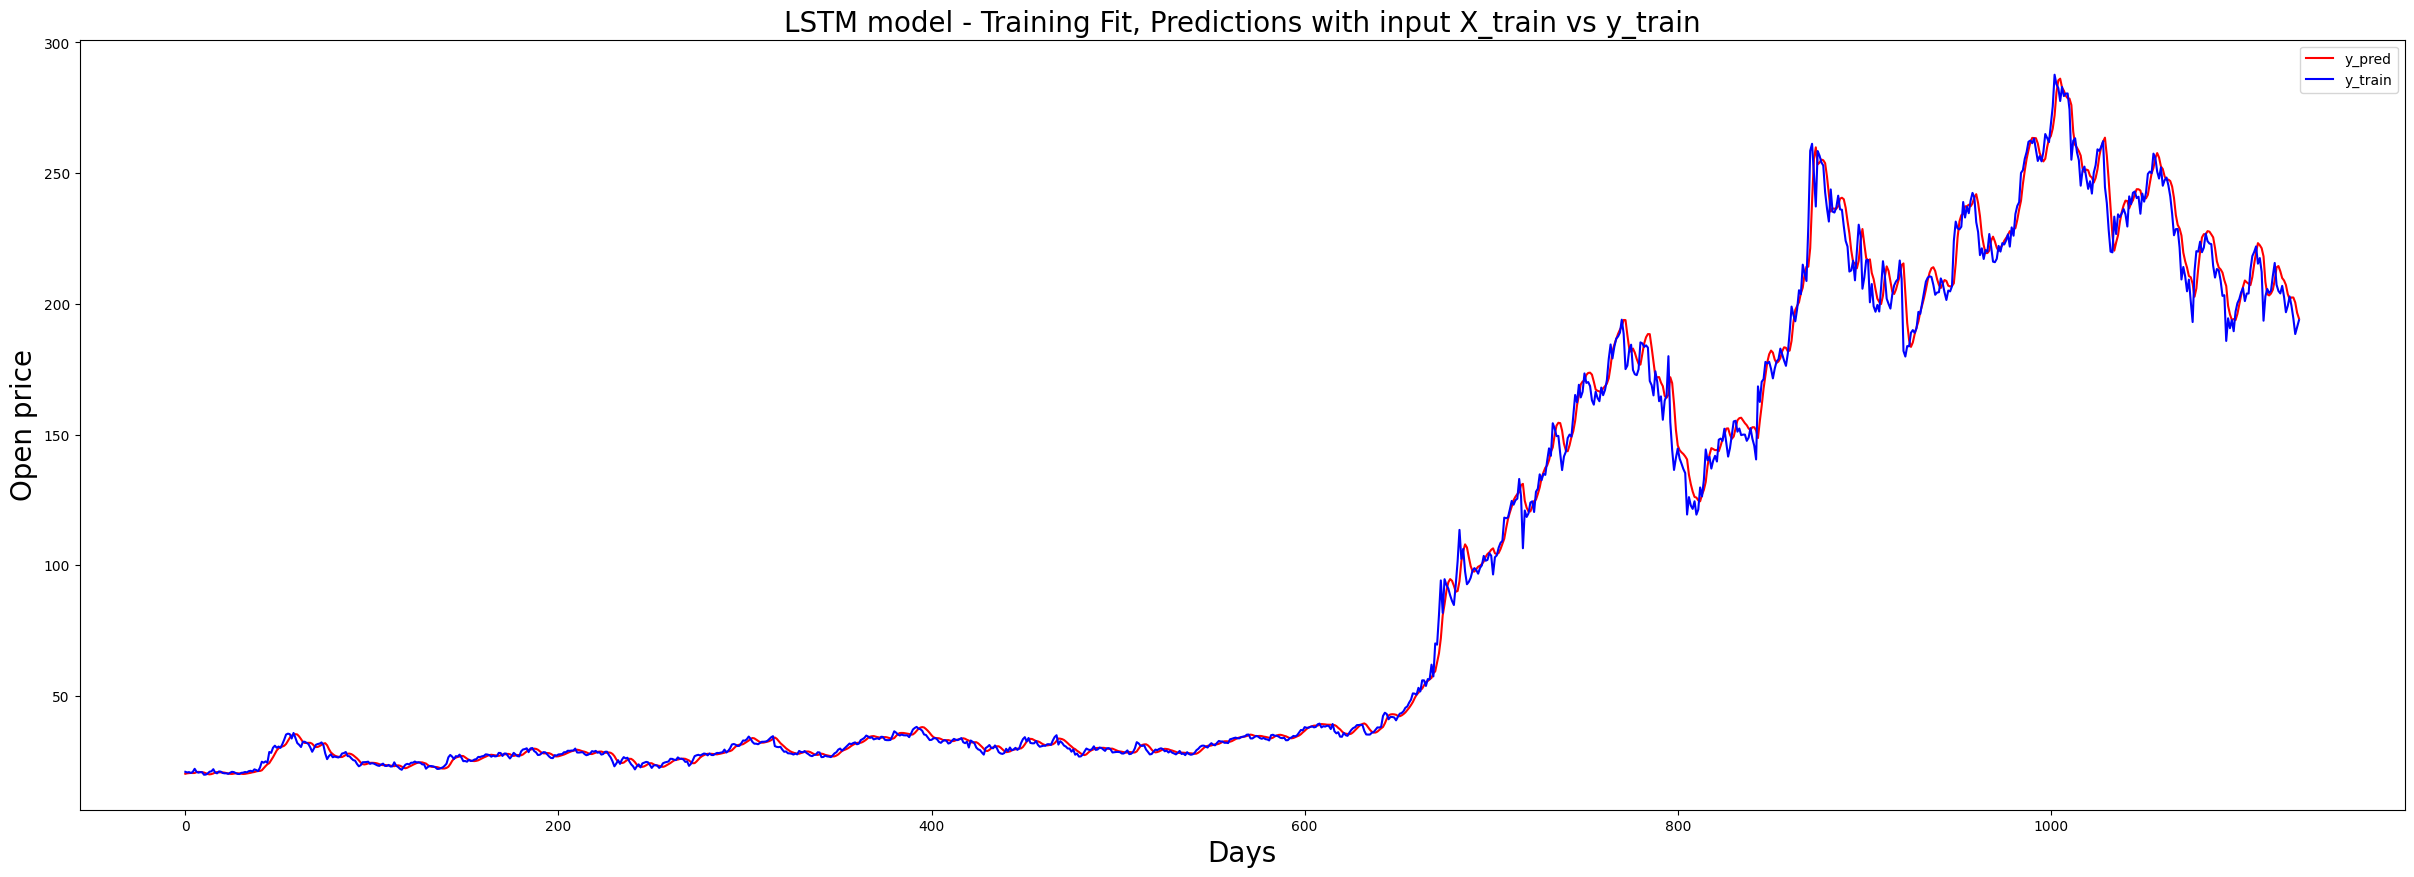

In [52]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_train, color = "r", label = "y_pred" )
plt.plot(y_train, color = "b", label = "y_train")
plt.xlabel("Days", fontsize = 20)
plt.ylabel("Open price", fontsize = 20)
plt.title("LSTM model - Training Fit, Predictions with input X_train vs y_train", fontsize = 20)
plt.legend()
plt.show()

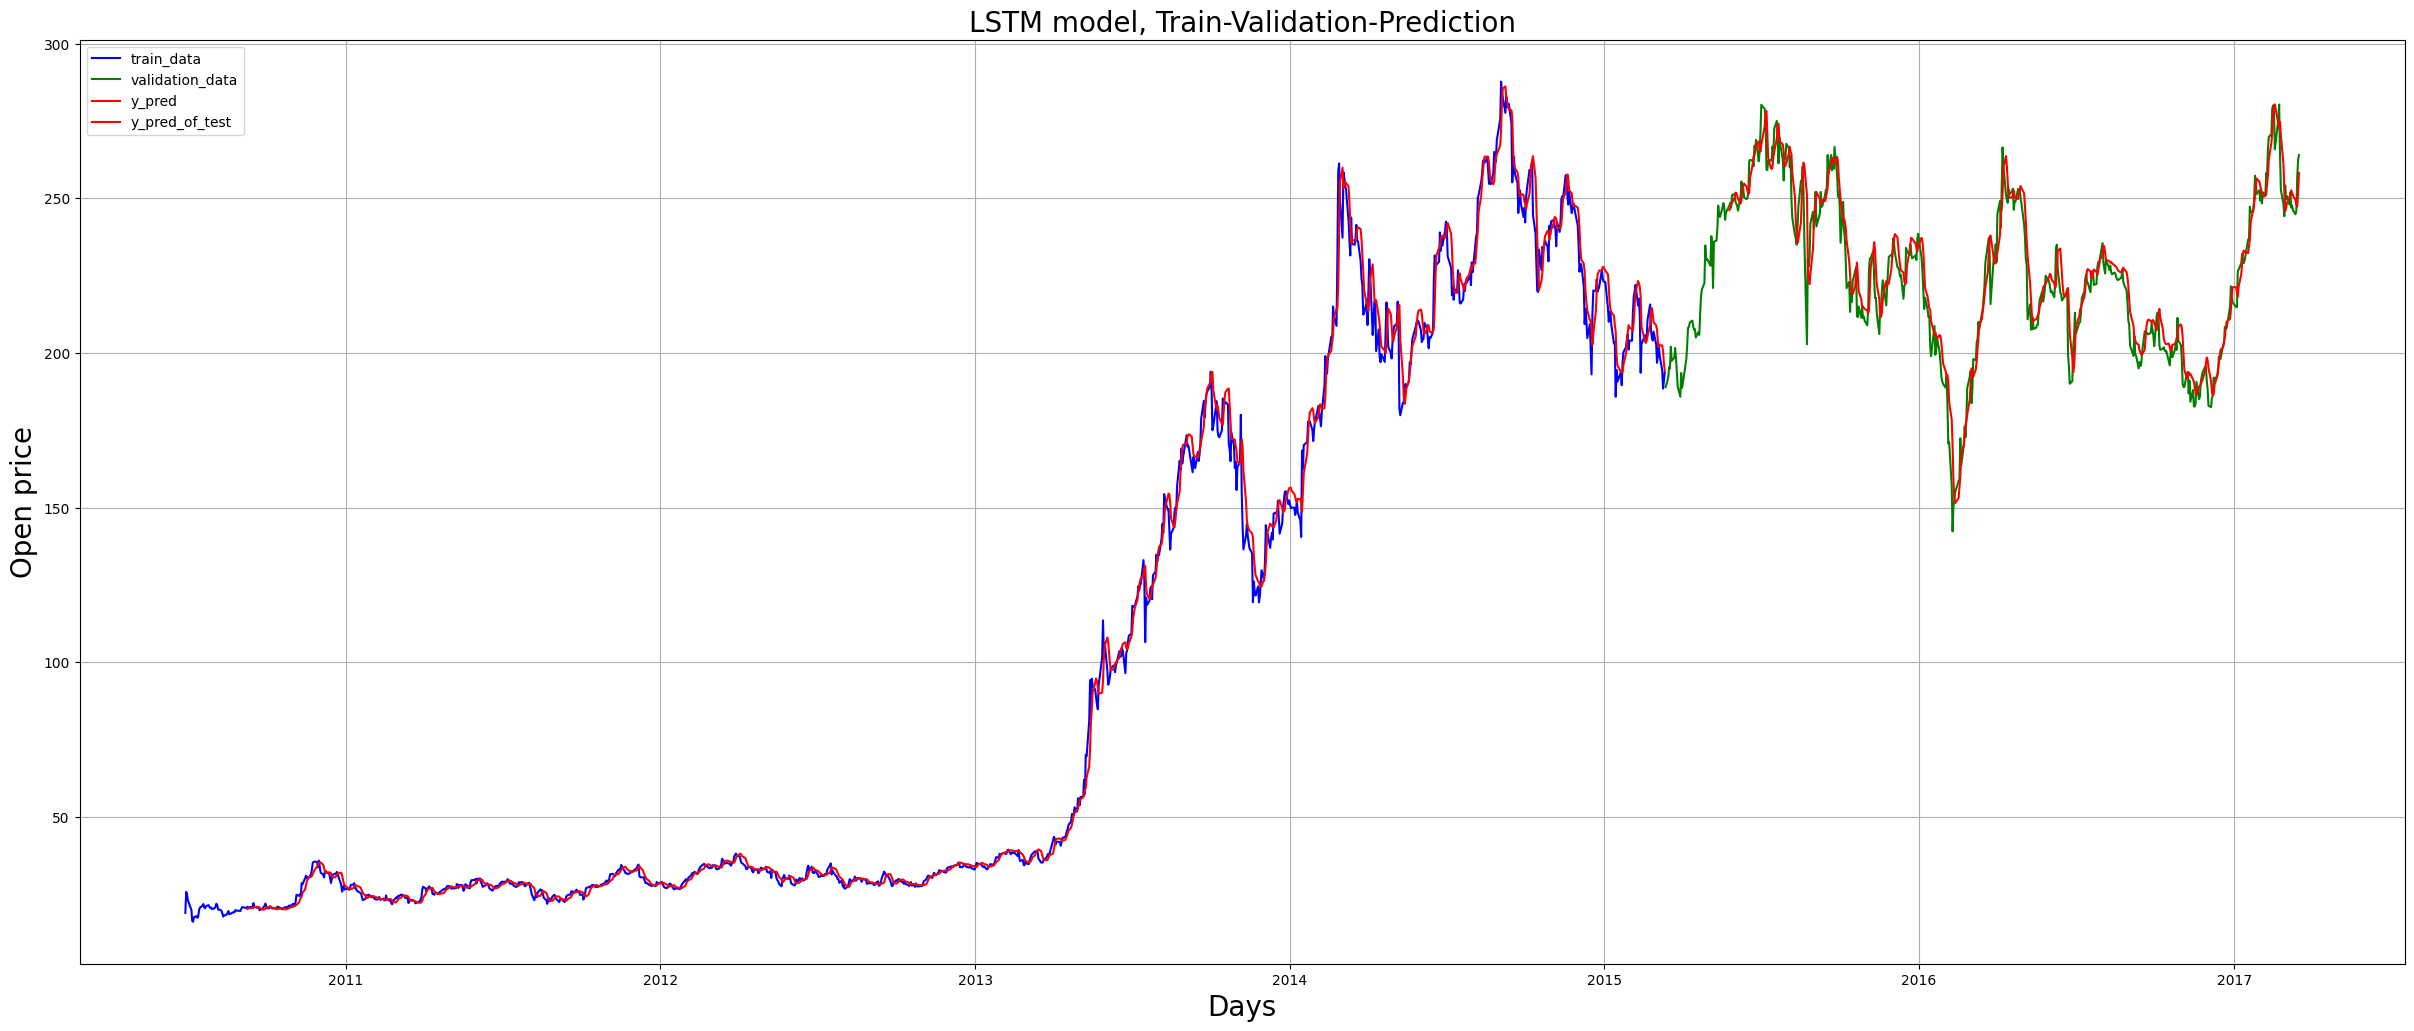

In [55]:
# Visualisation
plt.subplots(figsize =(30,12))
plt.plot(train_data.Date, train_data.Open, label = "train_data", color = "b")
plt.plot(validation_data.Date, validation_data.Open, label = "validation_data", color = "g")
plt.plot(train_data.Date.iloc[time_step:], y_pred_of_train, label = "y_pred", color = "r")
plt.plot(validation_data.Date.iloc[time_step:], y_pred_of_test, label = "y_pred_of_test", color = "r")
plt.xlabel("Days", fontsize = 20)
plt.ylabel("Open price", fontsize = 20)
plt.title("LSTM model, Train-Validation-Prediction", fontsize = 20)
plt.legend()
plt.grid(True)
plt.show()

In [56]:
import plotly.graph_objects as go

# Convert predictions to 1D for Plotly
y_pred_train_flat = y_pred_of_train.flatten()
y_pred_test_flat = y_pred_of_test.flatten()

# Trim dates to match prediction arrays
train_dates_trimmed = train_data.Date.iloc[time_step:].reset_index(drop=True)
val_dates_trimmed = validation_data.Date.iloc[time_step:].reset_index(drop=True)

# Initialize figure
fig = go.Figure()

# Train Data
fig.add_trace(go.Scatter(
    x=train_data.Date,
    y=train_data.Open,
    mode='lines',
    name='train_data',
    line=dict(color='blue')
))

# Validation Data
fig.add_trace(go.Scatter(
    x=validation_data.Date,
    y=validation_data.Open,
    mode='lines',
    name='validation_data',
    line=dict(color='green')
))

# Train Predictions
fig.add_trace(go.Scatter(
    x=train_dates_trimmed,
    y=y_pred_train_flat,
    mode='lines',
    name='y_pred_of_train',
    line=dict(color='orange')
))

# Validation/Test Predictions
fig.add_trace(go.Scatter(
    x=val_dates_trimmed,
    y=y_pred_test_flat,
    mode='lines',
    name='y_pred_of_test',
    line=dict(color='red')
))

# Update layout
fig.update_layout(
    title='LSTM model, Train-Validation-Prediction',
    xaxis_title='Days',
    yaxis_title='Open price',
    width=1200,
    height=600,
    legend=dict(x=0, y=1.0),
    template='plotly_dark',
    margin=dict(l=40, r=40, t=60, b=40)
)

fig.show()
